# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [147]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [201]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS/2020/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS/2020/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS/2020/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Defined Functions

In [4]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [5]:
def convert_kg_to_cms(df):

    # Calculate the number of seconds for each month
    df['seconds'] = df.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # Convert millimeters to meters
    df['WaterErie_m3'] = df['WaterErie'] / 1000
    df['WaterOntario_m3'] = df['WaterOntario'] / 1000
    df['WaterSuperior_m3'] = df['WaterSuperior'] / 1000
    df['WaterMichHuron_m3'] = (df['WaterMichigan'] + df['WaterHuron']) / 1000

    # Convert the data to cubic meters per second
    df['WaterErie_cms'] = df['WaterErie_m3'] / df['seconds']
    df['WaterOntario_cms'] = df['WaterOntario_m3'] / df['seconds']
    df['WaterSuperior_cms'] = df['WaterSuperior_m3'] / df['seconds']
    df['WaterMichHuron_cms'] = df['WaterMichHuron_m3'] / df['seconds']
    
    return df

In [6]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [202]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2019-01-01'
end_date = '2019-12-01'
obs = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = obs['sup']
er_rnbs = obs['eri']
on_rnbs = obs['ont']
mh_rnbs = obs['mic_hur']

In [203]:
print(obs)

           Date         sup     mic_hur        eri         ont  Month
1428 2019-01-01    2.942399   48.823210  101.21490  131.671800      1
1429 2019-02-01   71.165970   99.169600  166.65090  255.571600      2
1430 2019-03-01   60.482640  122.172600  112.81250  260.542000      3
1431 2019-04-01  197.425500  299.682700  288.74820  417.517900      4
1432 2019-05-01  199.429200  285.375100  215.08170  418.828300      5
1433 2019-06-01  107.887900  196.756900  229.57010  273.826700      6
1434 2019-07-01  122.599900   94.208160   26.35805  135.874100      7
1435 2019-08-01   58.847970   -7.334942  -66.42230    7.003818      8
1436 2019-09-01  134.780800  127.104500  -49.99528   37.956170      9
1437 2019-10-01   68.655970   79.309060  -89.61738  128.870200     10
1438 2019-11-01    7.909673   75.641590   12.24374  149.113500     11
1439 2019-12-01   35.962650  107.732000  -27.41238  222.721400     12


## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [204]:
# Convert Total Precipitation to cms
pcp_data = convert_kg_to_cms(pcp_data)

# Convert Total Evaporation to cms
evap_data = convert_kg_to_cms(evap_data)

In [205]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2019010100  2019      1  4.887577e+12  7.999486e+11  4.774506e+12   
1      2019010100  2019      2  4.670724e+12  7.483568e+11  4.563257e+12   
2      2019010100  2019      3  9.856284e+12  1.483492e+12  9.671997e+12   
3      2019010100  2019      4  1.312975e+13  2.061751e+12  1.283739e+13   
4      2019010100  2019      5  9.693159e+12  1.457385e+12  9.695645e+12   
...           ...   ...    ...           ...           ...           ...   
13819  2019123100  2020      5  5.204369e+12  8.694046e+11  5.052417e+12   
13820  2019123100  2020      6  1.099076e+13  1.522065e+12  1.158490e+13   
13821  2019123100  2020      7  6.516533e+12  9.531111e+11  6.539871e+12   
13822  2019123100  2020      8  5.543419e+12  9.084656e+11  5.717544e+12   
13823  2019123100  2020      9  7.918089e+12  1.382789e+12  7.353360e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      5.768671e+

In [206]:
# Features
X = pd.DataFrame({
    'su_pcp': pcp_data['WaterSuperior_cms'],
    'er_pcp': pcp_data['WaterErie_cms'],
    'on_pcp': pcp_data['WaterOntario_cms'],
    'mh_pcp': pcp_data['WaterMichHuron_cms'], #data_1['WaterMichigan']+data_1['WaterHuron'], # add the sums
    'su_evap': evap_data['WaterSuperior_cms'],
    'er_evap': evap_data['WaterErie_cms'],
    'on_evap': evap_data['WaterOntario_cms'],
    'mh_evap': evap_data['WaterMichHuron_cms'], #data_2['WaterMichigan']+data_2['WaterHuron'], # add the sums
    'su_tmp': tmp_data['WaterSuperior'],
    'er_tmp': tmp_data['WaterErie'],
    'on_tmp': tmp_data['WaterOntario'],
    'mh_tmp': (tmp_data['WaterMichigan']+tmp_data['WaterHuron'])/2 # take the average temp
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [207]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
print(df_y_pred)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


               sup          eri          ont          mih
0        -7.324884  1107.389616  1530.885710  2933.927748
1       449.081469   954.218003  1047.989324  3247.507574
2       522.871424  2488.675236  2388.286146  5655.677785
3       950.689141  2443.359166  2844.863985  8054.694840
4      2270.428004   796.396349   898.444179  3881.387608
...            ...          ...          ...          ...
13819  1649.205710   170.392321   363.462401  1443.872964
13820  2618.490611   331.095809   259.609905  1707.598239
13821  3158.473269  -526.859908   241.637030   939.031948
13822  3792.702571  -319.183112   161.481089   238.412288
13823  2808.544950   654.962538   872.490478  1567.661377

[13824 rows x 4 columns]


In [208]:
df = pd.DataFrame()
df['cfsrun'] = pcp_data['cfsrun']
df['month'] = pcp_data['month'].astype(int)
df['year'] = pcp_data['year'].astype(int)

In [209]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [210]:
print(df_y)

           cfsrun  month  year          sup          eri          ont  \
0      2019010100      1  2019    -7.324884  1107.389616  1530.885710   
1      2019010100      2  2019   449.081469   954.218003  1047.989324   
2      2019010100      3  2019   522.871424  2488.675236  2388.286146   
3      2019010100      4  2019   950.689141  2443.359166  2844.863985   
4      2019010100      5  2019  2270.428004   796.396349   898.444179   
...           ...    ...   ...          ...          ...          ...   
13819  2019123100      5  2020  1649.205710   170.392321   363.462401   
13820  2019123100      6  2020  2618.490611   331.095809   259.609905   
13821  2019123100      7  2020  3158.473269  -526.859908   241.637030   
13822  2019123100      8  2020  3792.702571  -319.183112   161.481089   
13823  2019123100      9  2020  2808.544950   654.962538   872.490478   

               mih  
0      2933.927748  
1      3247.507574  
2      5655.677785  
3      8054.694840  
4      3881.387608

Currently, we are only storing 1 set of model results

In [212]:
df_y.to_csv(dir+f'RNBS_forecasts_2019.csv',sep=',',index=False)

Convert component units from [cms] to [mm]

In [213]:
df_y_mm = convert_cms_to_mm(df_y)

In [214]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].median().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_y_mm,'sup')
mean_er, min_er, max_er = mean_min_max(df_y_mm,'eri')
mean_on, min_on, max_on = mean_min_max(df_y_mm,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_mm,'mih')

In [215]:
df_y_mm_filtered = df_y_mm[(df_y_mm['year'] == 2019)]
print(df_y_mm_filtered)

           cfsrun  month  year         sup         eri         ont  \
0      2019010100      1  2019   -0.238973  115.612253  215.704366   
1      2019010100      2  2019   13.233345   89.980284  133.373443   
2      2019010100      3  2019   17.058587  259.819441  336.513526   
3      2019010100      4  2019   30.015546  246.859753  387.915590   
4      2019010100      5  2019   74.072309   83.144338  126.592293   
...           ...    ...   ...         ...         ...         ...   
13549  2019122318     12  2019   52.527909  334.016859  378.169787   
13559  2019122400     12  2019  118.523669  298.686701  427.743036   
13569  2019122406     12  2019   69.670940  285.796739  385.782353   
13579  2019122412     12  2019  132.979000  273.918009  443.373868   
13589  2019122418     12  2019  151.684345  326.559217  408.783256   

              mih  seconds  
0      123.345714  2678400  
1      123.316491  2419200  
2      237.771231  2678400  
3      327.705175  2592000  
4      163.178

Begin plotting

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

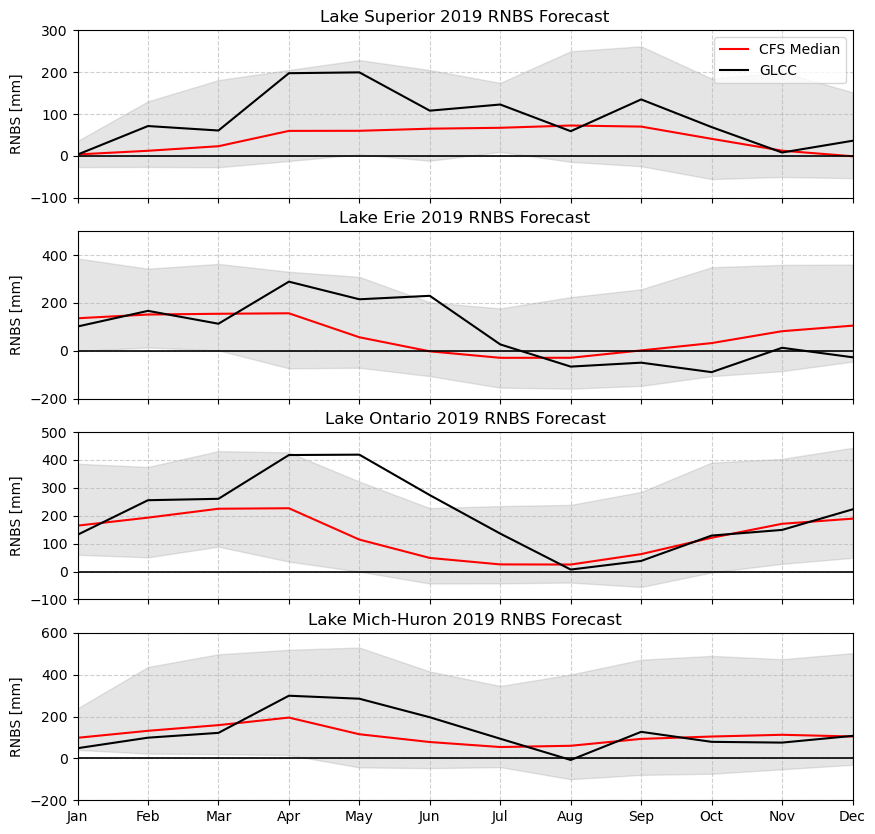

In [217]:
x_values = np.arange(0,12,1)  # x-axis values

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(x_values, mean_su['sup'][0:12], color='red', linestyle='-', linewidth=1.5, label='CFS Median')
axs[0].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_su['sup'][0:12], max_su['sup'][0:12], color='gray', alpha=0.2)
axs[0].set_ylabel('RNBS [mm]')
axs[0].set_title('Lake Superior 2019 RNBS Forecast')
axs[0].set_ylim(-100, 300)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].set_xticks(np.arange(0,12,1))
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_er['eri'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[1].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_er['eri'][0:12], max_er['eri'][0:12], color='gray', alpha=0.2)
axs[1].set_ylabel('RNBS [mm]')
axs[1].set_title('Lake Erie 2019 RNBS Forecast')
axs[1].set_ylim(-200, 500)
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].set_xticks(np.arange(0,12,1))
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on['ont'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on['ont'][0:12], max_on['ont'][0:12], color='gray', alpha=0.2)
axs[2].set_ylabel('RNBS [mm]')
axs[2].set_title('Lake Ontario 2019 RNBS Forecast')
axs[2].set_ylim(-100, 500)
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].set_xticks(np.arange(0,12,1))
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh['mih'][0:12], color='red', linestyle='-', linewidth=1.5, label='Mean')
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, label='Mean')
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh['mih'][0:12], max_mh['mih'][0:12], color='gray', alpha=0.2)
axs[3].set_ylabel('RNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2019 RNBS Forecast')
axs[3].set_ylim(-200, 600)
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].set_xticks(np.arange(0,12,1))
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels([calendar.month_abbr[mean_mh['month'][j]] for j in range(12)])

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\25999099.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3772\25999099.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


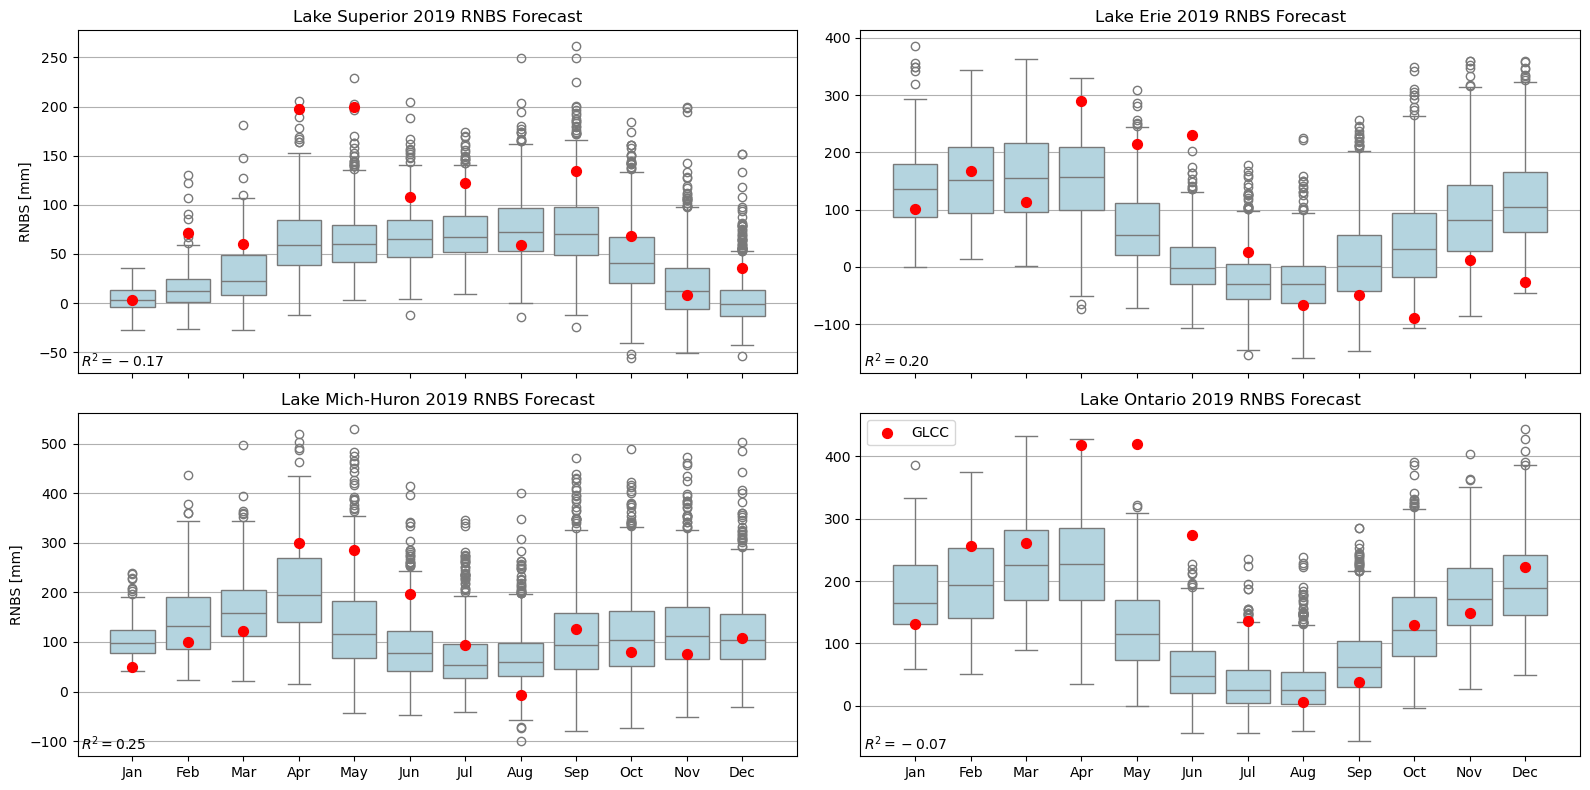

In [218]:
import seaborn as sns
from sklearn.metrics import r2_score

months = np.arange(0, 12)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# First boxplot
sns.boxplot(x='month', y='sup', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 0])
axes[0, 0].set_title('Lake Superior 2019 RNBS Forecast')
# Scatter plot for observations
axes[0, 0].scatter(obs['Month']-1, obs['sup'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 0].set_ylabel('RNBS [mm]')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticklabels('')
axes[0, 0].grid(axis='y')

r2_1 = r2_score(obs['sup'],df_y_mm_filtered.groupby('month')['sup'].median())
axes[0, 0].text(0.005, 0.009, f'$R^2 = {r2_1:.2f}$', ha='left', va='bottom', transform=axes[0, 0].transAxes)

# Second boxplot
sns.boxplot(x='month', y='eri', data=df_y_mm_filtered, color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Lake Erie 2019 RNBS Forecast')
# Scatter plot for observations
axes[0, 1].scatter(obs['Month']-1, obs['eri'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels('')
axes[0, 1].grid(axis='y')

r2_2 = r2_score(obs['eri'],df_y_mm_filtered.groupby('month')['eri'].median())
axes[0, 1].text(0.005, 0.009, f'$R^2 = {r2_2:.2f}$', ha='left', va='bottom', transform=axes[0, 1].transAxes)

# Third boxplot
sns.boxplot(x='month', y='mih', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 0])
axes[1, 0].set_title('Lake Mich-Huron 2019 RNBS Forecast')
# Scatter plot for observations
axes[1, 0].scatter(obs['Month']-1, obs['mic_hur'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 0].set_ylabel('RNBS [mm]')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(axis='y')

r2_3 = r2_score(obs['mic_hur'],df_y_mm_filtered.groupby('month')['mih'].median())
axes[1, 0].text(0.005, 0.009, f'$R^2 = {r2_3:.2f}$', ha='left', va='bottom', transform=axes[1, 0].transAxes)

# Fourth boxplot
sns.boxplot(x='month', y='ont', data=df_y_mm_filtered, color='lightblue', ax=axes[1, 1])
axes[1, 1].set_title('Lake Ontario 2019 RNBS Forecast')
# Scatter plot for observations
axes[1, 1].scatter(obs['Month']-1, obs['ont'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].grid(axis='y')
axes[1, 1].legend()

r2_4 = r2_score(obs['ont'],df_y_mm_filtered.groupby('month')['ont'].median())
axes[1, 1].text(0.005, 0.009, f'$R^2 = {r2_4:.2f}$', ha='left', va='bottom', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

In [164]:
# Calculate important statistics
stats = df_y_mm_filtered.groupby('month')['mih'].describe()
print("Important values:\n", stats)

Important values:
         count        mean        std        min         25%         50%  \
month                                                                     
1        96.0  147.561776  65.129004  37.151777  105.544173  133.049028   
2       212.0  113.921754  53.589853  17.549025   75.995269  104.633857   
3       324.0  166.229172  91.657843  16.774826   89.683861  154.784663   
4       448.0  200.058484  98.638856   4.909243  125.499832  183.181960   
5       564.0  126.100136  80.623030 -48.755846   68.451523  112.291809   
6       672.0   89.702666  68.600178 -45.278379   43.306190   74.403928   
7       788.0   56.095150  52.125485 -69.819651   19.790410   50.185117   
8       912.0   57.301317  51.322189 -52.470353   21.981044   49.941617   
9      1036.0   74.422424  72.293883 -89.071502   25.081591   65.263563   
10     1156.0   90.218165  79.982790 -87.735831   34.248795   78.391561   
11     1156.0  109.171865  77.758431 -47.335164   53.952417   99.378338   
12    